In [1]:
import struct
from PIL import Image
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import skimage.io as io
from skimage.filters import threshold_otsu

import math
import matplotlib.image as img

import cv2

%matplotlib inline

In [2]:
#씨닝알고리즘 함수
def neighbours(x,y,image):
    "해당하는 점에 대하여 주변 픽셀 8개를 지정해줌"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9


def transitions(neighbours):
    "주변 픽셀을 9시방향부터 시작하여 시계방향으로 돌렸을 때 두픽셀이 0->1로 되는 갯수"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def candel(x,y,image):
    result=True
    checkingD=[image[x][y-1],image[x+1][y],image[x][y+1],image[x-1][y]]
    if sum(checkingD)==3:
        result=False
    return result
    
def checkdump(x,y,image,changing3):
    img = image
    
    dump=[ image[x][y],image[x+1][y], image[x+1][y+1], image[x][y+1] ] #여기부터 하면 됨
    isdump=sum(dump)
    
    if isdump==4:
        for i in range(x,x+2):
            for j in range(y,y+2):
                if candel(i,j,image)==False:
                    changing3.append((i,j))
                    image[i][j]=0
                    
                    
                    
                    
def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # 이미지를 복사하여 넣음
    changing1 = changing2 = 1        #  초기는 시작을 하기위해 1로 지정
    while changing1 or changing2:   #  step1과 step2가 더이상 만족하지 못할 때 반복문을 나감
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(2, rows - 2):                     # No. of  rows
            for y in range(2, columns - 2):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                
                if (Image_Thinned[x][y] == 1     and    # Condition 0: 해당 픽셀이 검은색인지 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6 
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(2, rows - 2):
            for y in range(2, columns - 2):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
            
          
    changing3=1
    while changing3: #픽셀 중간에 빈공간을 메꿔줌
        changing3 = []
        rows, columns = Image_Thinned.shape
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):
                checkdump(x,y,Image_Thinned,changing3)
        
        
        
        
    return Image_Thinned

In [3]:
#빈칸 체워주기
def checkdump2(x,y,image):
    img = image
    
    dump=[ image[x][y],image[x+1][y], image[x+1][y+1], image[x][y+1] ] #여기부터 하면 됨
    isdump=sum(dump)
    allsum=0
    
    if isdump==0:   
        for i in range(x-1,x+3):
            if image[i][y-1]==1:
                allsum+=1
            if image[i][y+2]==1:
                allsum+=1
        for j in range(y,y+2):
            if image[x-1][j]==1:
                allsum+=1
            if image[x+2][j]==1:
                allsum+=1    
                
    return allsum
            
    
def painting(image):
    Image_ref=image.copy()
    rows, columns = Image_ref.shape 
    paintchange1=paintchange2=1
    while paintchange1:
        paintchange1=[]
        for x in range(2,rows-2):
            for y in range(2,columns-2):
                n1 = checkdump2(x, y, Image_ref)
                if (Image_ref[x][y]==0 and n1>=11):
                    paintchange1.append((x,y))
                    
        for x,y in paintchange1:
            Image_ref[x][y] = 1
    
    while paintchange2:
        paintchange2=[]
        for x in range(2,rows-2):
            for y in range(2,columns-2):
                n2 = neighbours(x, y, Image_ref)
                if (Image_ref[x][y]==0 and sum(n2)>=7):
                    paintchange2.append((x,y))
                    
        for x,y in paintchange2:
            Image_ref[x][y] = 1
    
    
    return Image_ref

In [4]:
def image_save(image,dirname,filenumber):
    if figure==b'0' or figure==b'p':
        image.save("complete/{0}/0/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'1' or figure==b'q':
        image.save("complete/{0}/1/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'2' or figure==b'w' or figure==b'i':
        image.save("complete/{0}/2/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'3' or figure==b'e':
        image.save("complete/{0}/3/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'4' or figure==b'r':
        image.save("complete/{0}/4/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'5' or figure==b't':
        image.save("complete/{0}/5/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'6' or figure==b'y':
        image.save("complete/{0}/6/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'7' or figure==b'u':
        image.save("complete/{0}/7/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'8':
        image.save("complete/{0}/8/{0}{1}.bmp".format(dirname,filenumber))
    elif figure==b'9' or figure==b'o' or figure==b'':
        image.save("complete/{0}/9/{0}{1}.bmp".format(dirname,filenumber))
    else:
        image.save("complete/{0}/bins/{0}{1}.bmp".format(dirname,filenumber))
    

In [5]:

def breaking(neighbours):
    "주변 픽셀을 검사하여 180도(1자)인 픽셀 제거"
    vertical = neighbours[0]+neighbours[4]
    horizontal = neighbours[2]+neighbours[6]
    
    diagonal_LU = neighbours[5]+neighbours[1]
    diagonal_RU = neighbours[3]+neighbours[7]
    
    result=True
    if (np.sum(vertical)==2 and np.sum(horizontal)!=2 and np.sum(diagonal_LU)!=2 and np.sum(diagonal_RU)!=2 ):
        result=False
    if(np.sum(vertical)!=2 and np.sum(horizontal)==2 and np.sum(diagonal_LU)!=2 and np.sum(diagonal_RU)!=2 ):
        result=False
    if(np.sum(vertical)!=2 and np.sum(horizontal)!=2 and np.sum(diagonal_LU)==2 and np.sum(diagonal_RU)!=2 ):
        result=False
    if(np.sum(vertical)!=2 and np.sum(horizontal)!=2 and np.sum(diagonal_LU)!=2 and np.sum(diagonal_RU)==2 ):
        result=False    
    return result



In [6]:
def findingF(x,y,footprint,getfeature,getbp,tail,bifur,directnum):
    #print("진행중인 위치",x,y)
    #print("directnum",directnum)
    #print("footprint",footprint)
    gonum=directnum
    if gonum==0:
        if (x,y-1) in testXY and not (x,y-1) in footprint :
            
            footprint.append((x,y-1))
            if (x,y-1) in getbp or (x,y-1) in bifur or (x,y-1) in tail:
                getfeature.append((x,y-1))
            else:
                aftergonum=1
                #print("11")
                findingF(x,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x+1,y) in testXY and not (x+1,y) in footprint:
            footprint.append((x+1,y))
            if (x+1,y) in getbp or (x+1,y) in bifur or (x+1,y) in tail:
                getfeature.append((x+1,y))
            else:
                aftergonum=2
                #print("22")
                findingF(x+1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x,y+1) in testXY and not (x,y+1) in footprint:
            footprint.append((x,y+1))
            if (x,y+1) in getbp or (x,y+1) in bifur or (x,y+1) in tail:
                getfeature.append((x,y+1))
            else:
                aftergonum=3
                #print("33")
                findingF(x,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x-1,y) in testXY and not (x-1,y) in footprint:
            footprint.append((x-1,y))
            if (x-1,y) in getbp or (x-1,y) in bifur or (x-1,y) in tail:
                getfeature.append((x-1,y))
            else:
                aftergonum=4
                #print("44")
                findingF(x-1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)

        ########################################

        elif (x+1,y-1) in testXY and not (x+1,y-1) in footprint:
            footprint.append((x+1,y-1))
            if (x+1,y-1) in getbp or (x+1,y-1) in bifur or (x+1,y-1) in tail:
                getfeature.append((x+1,y-1))
            else:
                aftergonum=0
                #print("55")
                findingF(x+1,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x+1,y+1) in testXY and not (x+1,y+1) in footprint:
            footprint.append((x+1,y+1))
            if (x+1,y+1) in getbp or (x+1,y+1) in bifur or (x+1,y+1) in tail:
                getfeature.append((x+1,y+1))
            else:
                aftergonum=0
                #print("66")
                findingF(x+1,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x-1,y+1) in testXY and not (x-1,y+1) in footprint:
            footprint.append((x-1,y+1))
            if (x-1,y+1) in getbp or (x-1,y+1) in bifur or (x-1,y+1) in tail:
                getfeature.append((x-1,y+1))
            else:
                aftergonum=0
                #print("77")
                findingF(x-1,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x-1,y-1) in testXY and not (x-1,y-1) in footprint:
            footprint.append((x-1,y-1))
            if (x-1,y-1) in getbp or (x-1,y-1) in bifur or (x-1,y-1) in tail:
                getfeature.append((x-1,y-1))
            else:
                aftergonum=0
                #print("88")
                findingF(x-1,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
    
    
    
    elif gonum==1:
        if (x,y-1) in testXY and not (x,y-1) in footprint :
            
            footprint.append((x,y-1))
            if (x,y-1) in getbp or (x,y-1) in bifur or (x,y-1) in tail:
                
                getfeature.append((x,y-1))
            else:
                aftergonum=1
                #print("99")
                findingF(x,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x+1,y) in testXY and not (x+1,y) in footprint:
            footprint.append((x+1,y))
            if (x+1,y) in getbp or (x+1,y) in bifur or (x+1,y) in tail:
                getfeature.append((x+1,y))
            else:
                aftergonum=2
                #print("1010")
                findingF(x+1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x-1,y) in testXY and not (x-1,y) in footprint:
            footprint.append((x-1,y))
            if (x-1,y) in getbp or (x-1,y) in bifur or (x-1,y) in tail:
                getfeature.append((x-1,y))
            else:
                aftergonum=4
                #print("1111")
                findingF(x-1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)

        ########################################

        elif (x+1,y-1) in testXY and not (x+1,y-1) in footprint:#5
            footprint.append((x+1,y-1))
            if (x+1,y-1) in getbp or (x+1,y-1) in bifur or (x+1,y-1) in tail:
                getfeature.append((x+1,y-1))
            else:
                aftergonum=0
                #print("1212")
                findingF(x+1,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x-1,y-1) in testXY and not (x-1,y-1) in footprint:#8
            footprint.append((x-1,y-1))
            if (x-1,y-1) in getbp or (x-1,y-1) in bifur or (x-1,y-1) in tail:
                getfeature.append((x-1,y-1))
            else:
                aftergonum=0
                #print("1313")
                findingF(x-1,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
                
                
                
        
    elif gonum==2:
        if (x,y-1) in testXY and not (x,y-1) in footprint :
            footprint.append((x,y-1))
            if (x,y-1) in getbp or (x,y-1) in bifur or (x,y-1) in tail:
                getfeature.append((x,y-1))
            else:
                aftergonum=1
                #print("1414")
                findingF(x,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x+1,y) in testXY and not (x+1,y) in footprint:
            footprint.append((x+1,y))
            if (x+1,y) in getbp or (x+1,y) in bifur or (x+1,y) in tail:
                getfeature.append((x+1,y))
            else:
                aftergonum=2
                #print("1515")
                findingF(x+1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x,y+1) in testXY and not (x,y+1) in footprint:
            footprint.append((x,y+1))
            if (x,y+1) in getbp or (x,y+1) in bifur or (x,y+1) in tail:
                getfeature.append((x,y+1))
            else:
                aftergonum=3
                #print("1616")
                findingF(x,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)


        ########################################

        elif (x+1,y-1) in testXY and not (x+1,y-1) in footprint:#5
            footprint.append((x+1,y-1))
            if (x+1,y-1) in getbp or (x+1,y-1) in bifur or (x+1,y-1) in tail:
                getfeature.append((x+1,y-1))
            else:
                aftergonum=0
                #print("1717")
                findingF(x+1,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
        elif (x+1,y+1) in testXY and not (x+1,y+1) in footprint:#6
            footprint.append((x+1,y+1))
            if (x+1,y+1) in getbp or (x+1,y+1) in bifur or (x+1,y+1) in tail:
                getfeature.append((x+1,y+1))
            else:
                aftergonum=0
                #print("1818")
                findingF(x+1,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
    
    
    
    
    
    elif gonum==3:
        if (x+1,y) in testXY and not (x+1,y) in footprint:
            footprint.append((x+1,y))
            if (x+1,y) in getbp or (x+1,y) in bifur or (x+1,y) in tail:
                getfeature.append((x+1,y))
            else:
                aftergonum=2
                #print("1919")
                findingF(x+1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x,y+1) in testXY and not (x,y+1) in footprint:
            footprint.append((x,y+1))
            if (x,y+1) in getbp or (x,y+1) in bifur or (x,y+1) in tail:
                getfeature.append((x,y+1))
            else:
                aftergonum=3
                #print("2020")
                findingF(x,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x-1,y) in testXY and not (x-1,y) in footprint:
            footprint.append((x-1,y))
            if (x-1,y) in getbp or (x-1,y) in bifur or (x-1,y) in tail:
                getfeature.append((x-1,y))
            else:
                aftergonum=4
                #print("2121")
                findingF(x-1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)

        ########################################

        elif (x+1,y+1) in testXY and not (x+1,y+1) in footprint:#6
            footprint.append((x+1,y+1))
            if (x+1,y+1) in getbp or (x+1,y+1) in bifur or (x+1,y+1) in tail:
                getfeature.append((x+1,y+1))
            else:
                aftergonum=0
                #print("2222")
                findingF(x+1,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x-1,y+1) in testXY and not (x-1,y+1) in footprint:#7
            footprint.append((x-1,y+1))
            if (x-1,y+1) in getbp or (x-1,y+1) in bifur or (x-1,y+1) in tail:
                getfeature.append((x-1,y+1))
            else:
                aftergonum=0
                #print("2323")
                findingF(x-1,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
                
                
                
                
    elif gonum==4:
        if (x,y-1) in testXY and not (x,y-1) in footprint :
            
            footprint.append((x,y-1))
            if (x,y-1) in getbp or (x,y-1) in bifur or (x,y-1) in tail:
                getfeature.append((x,y-1))
            else:
                aftergonum=1
                #print("2424")
                findingF(x,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        
        elif (x,y+1) in testXY and not (x,y+1) in footprint:
            footprint.append((x,y+1))
            if (x,y+1) in getbp or (x,y+1) in bifur or (x,y+1) in tail:
                getfeature.append((x,y+1))
            else:
                aftergonum=3
                #print("2525")
                findingF(x,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x-1,y) in testXY and not (x-1,y) in footprint:
            footprint.append((x-1,y))
            if (x-1,y) in getbp or (x-1,y) in bifur or (x-1,y) in tail:
                getfeature.append((x-1,y))
            else:
                aftergonum=4
                #print("2626")
                findingF(x-1,y,footprint,getfeature,getbp,tail,bifur,aftergonum)

        ########################################

        
        elif (x-1,y+1) in testXY and not (x-1,y+1) in footprint:
            footprint.append((x-1,y+1))
            if (x-1,y+1) in getbp or (x-1,y+1) in bifur or (x-1,y+1) in tail:
                getfeature.append((x-1,y+1))
            else:
                aftergonum=0
                #print("2727")
                findingF(x-1,y+1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        elif (x-1,y-1) in testXY and not (x-1,y-1) in footprint:
            footprint.append((x-1,y-1))
            if (x-1,y-1) in getbp or (x-1,y-1) in bifur or (x-1,y-1) in tail:
                getfeature.append((x-1,y-1))
            else:
                aftergonum=0
                #print("2828")
                findingF(x-1,y-1,footprint,getfeature,getbp,tail,bifur,aftergonum)
        




In [7]:
def featuring(image,testXY):
    
    
    "최종 연결된 점들"
    linkpoint=[]
    
    
    "끝점 분기점 꺽인점 찾기"
    Image_Thinned = image.copy()  # 이미지를 복사하여 넣음
       
    rows, columns = Image_Thinned.shape               # x for rows, y for columns
    #print(rows,columns)
    bifurcritical=7
    tailcritical=5
    pointgap=7
    Bnum1=12
    Bangle1=75
    
    Bnum2=10
    Bangle2=115
    
    imp=10
    if rows<35 or columns<35:
        bifurcritical=3
        tailcritical=3
        pointgap=4
        Bnum1=10
        Bangle1=70
        
        Bnum2=8
        Bangle2=120
        imp=8
    elif rows>60 and columns>60:
        bifurcritical=10
        
    #print("rows,columns",rows,columns)
    #print("")
    tail=[]
    bifur = []
    breakpoint = [] 

    tailcritical=(rows+columns)//2//7
    
    
    
    
    tempT=1
    while tempT:
        
        
        tempT=[]
        
        for x,y in testXY:
            P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
            if (Image_Thinned[x][y] == 1 and sum(n)<=3 and transitions(n) == 1):  #끝점 찾기
                tail.append((x,y)) 
                    # Step 분기점
            elif (Image_Thinned[x][y] == 1 and sum(n)==3 and transitions(n) == 1):
                Image_Thinned[x][y] = 0
            elif (Image_Thinned[x][y] == 1 and sum(n) >= 3 and transitions(n) >= 3): # 분기점 찾기
                bifur.append((x,y)) 
            elif (Image_Thinned[x][y] == 1 and sum(n) == 6 and transitions(n) == 2):
                bifur.append((x,y)) 
        
        for x1, y1 in tail: # 세선화로 발생한 노이즈 제거
            for x2,y2 in bifur:
                length=math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                if length<bifurcritical: 
                    tempT.append((x1,y1))
        
        for x,y in tempT:
            Image_Thinned[x][y] = 0
            if (x,y) in testXY:
                testXY.remove((x,y))
        
               
        if tempT: #노이즈가 있다면 다시 재검사!
            del tail[:]
            del bifur[:]
            del breakpoint[:]
            
        else:
            del tail[:]
            del bifur[:]
            del breakpoint[:]
            
            tempB=[]
            
            for x,y in testXY:
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1 and sum(n)<3 and transitions(n) == 1):  #끝점 찾기
                    tail.append((x,y)) 
                        # Step 분기점
                elif (Image_Thinned[x][y] == 1 and sum(n)==3 and transitions(n) == 1):
                    Image_Thinned[x][y] = 0
                elif (Image_Thinned[x][y] == 1 and sum(n) >= 3 and transitions(n) >= 3): # 분기점 찾기
                    bifur.append((x,y)) 
                elif (Image_Thinned[x][y] == 1 and sum(n) == 6 and transitions(n) == 2):
                    bifur.append((x,y)) 
                elif Image_Thinned[x][y] == 1 and transitions(n) == 2 and breaking(n)==True: #꺾인점 후보 찾기
                    breakpoint.append((x,y))
                    
            for x1,y1 in breakpoint:# 특징점 주변을 검사하지 않음
                        
                for x2,y2 in bifur:
                    length=math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                    if length<tailcritical:
                        tempB.append((x1,y1))
                for x3,y3 in tail:
                    length=math.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
                    if length<tailcritical and not (x1,y1) in tempB:
                        tempB.append((x1,y1))
                    
    breakpoint=set(breakpoint)-set(tempB)
    #####################################################################
            
    
    
    getbp=[]
    binbp=[]
    for x1,y1 in breakpoint:        #꺾은점 후보들이 너무 자잘하게 붙어있기에 그중 후보들을 고름
        if not (x1,y1) in binbp:
            for x2,y2 in breakpoint:
                length=math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)#1
                if length<pointgap:
                        binbp.append((x2,y2))
                        if not (x1,y1) in getbp:
                            getbp.append((x1,y1))
                            

                
#     gettail=[]
#     bintail=[]
#     for x1,y1 in tail: #끝점 주변 끝점이 있을 시 통일 
#         if not (x1,y1) in bintail:
#             for x2,y2 in tail:
#                 length=math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)#2
#                 if length<3:
#                         bintail.append((x2,y2))
#                         if not (x1,y1) in gettail:
#                             gettail.append((x1,y1))            
                            
#     removeT=[]
#     for x1, y1 in gettail:   #끝점 두개가 가까이있으면 끊어진 선으로 판단하여 이어줌
#         for x2, y2 in gettail:
#             if (x1,y1)!=(x2,y2):
#                 length=math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
#                 if length<6: 
#                     x3=(x1+x2)//2
#                     y3=(y1+y2)//2
#                     if not (x3,y3) in getbp:
#                         getbp.append((x3,y3))
#                         removeT.append((x1,y1))
#                         removeT.append((x2,y2))

#     gettail=set(gettail)-set(removeT)
    
    
                        
#     getbf=[]
#     binbf=[]
#     for x1,y1 in bifur: #분기점 주변 분기점이 있을 시 하나로 통일
#         if not (x1,y1) in binbf:
#             for x2,y2 in bifur:
#                 length=math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)#3
#                 if length<3:
#                         binbf.append((x2,y2))
#                         if not (x1,y1) in getbf:
#                             getbf.append((x1,y1))                              
                        
                        
    #allfeature=set(getbp)|set(tail)|set(bifur)
    ##print(allfeature)
    
    ##print("getbp값",getbp)
    ##print("tail값",tail)
    ##print("bifur값",bifur)
    breakresults1=[] 
    T=0
    while len(breakresults1)<Bnum1 and T<=Bangle1:
        
        for x1,y1 in getbp: #각 꺾은 점의 가까운 점들과의 각도를 구하여 각도가 유별난 점을 추출

            footprint=[]
            #print("현재 검사 위치는 : ", x1,y1)
            footprint.append((x1,y1))
            getfeature=[]
            errors=0
            
            while len(getfeature)<=1 and errors<500:
                
                directnum=0
                findingF(x1,y1,footprint,getfeature,getbp,tail,bifur,directnum)
                errors+=1
                #print(getfeature)
                
            #print("연결된 위치는 :",getfeature)
            
            
            if len(getfeature)==2:
                xr2=getfeature[0][0]
                yr2=getfeature[0][1]
                xr3=getfeature[1][0]
                yr3=getfeature[1][1]

                xx1=xr2-x1
                yy1=yr2-y1
                if xx1==0:
                    xx1=0.000000000001 # atan를 구할때 y/x에서 x가 0이 되게 하지 않기위함

                xx2=xr3-x1
                yy2=yr3-y1
                if xx2==0:
                    xx2=0.000000000001

                angle=0
                o1=0
                o2=0
                geto1=0
                geto2=0
                #반시계 방향으로 돌아 각도가 몇도인지 판단하기 위한 기준점을 세워줌
                if xx1>=0 and yy1>=0:  
                    o1 = math.atan(yy1/xx1)
                    geto1 = math.degrees(o1)

                elif xx1<=0 and yy1>=0: 
                    o1 = math.atan(yy1/xx1)
                    geto1 = 180 + math.degrees(o1)

                elif xx1<=0 and yy1<=0:
                    o1 = math.atan(yy1/xx1)
                    geto1 = 180 + math.degrees(o1)

                elif xx1>=0 and yy1<=0:
                    o1 = math.atan(yy1/xx1)
                    geto1 = 360 + math.degrees(o1)

                # x1,y1 x2,y2 각각을 다 계산해야함 둔각 예각일때가 있으므로 
                if xx2>=0 and yy2>=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = math.degrees(o2)

                elif xx2<=0 and yy2>=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = 180 + math.degrees(o2)

                elif xx2<=0 and yy2<=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = 180 + math.degrees(o2)

                elif xx2>=0 and yy2<=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = 360 + math.degrees(o2)



                angle=abs(geto1-geto2)

                if angle>180:
                    angle=360-angle
                #print("xy와 각도",x1,y1,angle)
                #print("인접1 점 각도",xr2,yr2,geto1)
                #print("인접2 점 각도",xr3,yr3,geto2)
                #print()


                if angle>15 and angle<95+T  and xr3!=0 and yr3!=0 and not (x1,y1) in breakresults1 :
                    breakresults1.append((x1,y1))
#                     if not {(x1,y1),(xr2,yr2)} in linkpoint:
#                         linkpoint.append({(x1,y1),(xr2,yr2)})
#                     if not {(x1,y1),(xr3,yr3)} in linkpoint:
#                         linkpoint.append({(x1,y1),(xr3,yr3)})
        T+=0.25
        
    
    #####################################################################
    breakresults2=[] 
    #print(breakresults1)
    #print(bifur)
    #print(tail)
    #print(len(breakresults2)+len(bifur)+len(tail))
    T1=0
    while (len(breakresults2)+len(bifur)+len(tail))<Bnum2 and T1<=Bangle2:
        #print("와일문 들어감")
        for x1,y1 in breakresults1: #각 꺾은 점의 가까운 점들과의 각도를 구하여 각도가 유별난 점을 추출

            footprint=[]
            #print("현재 검사 위치는 : ", x1,y1)
            footprint.append((x1,y1))
            getfeature=[]
            errors=0
            
            while len(getfeature)<=1 and errors<500:
                
                directnum=0
                findingF(x1,y1,footprint,getfeature,breakresults1,tail,bifur,directnum)
                errors+=1
                #print(getfeature)
                
            #print("연결된 위치는 :",getfeature)
            
            
            if len(getfeature)==2:
                xr2=getfeature[0][0]
                yr2=getfeature[0][1]
                xr3=getfeature[1][0]
                yr3=getfeature[1][1]

                xx1=xr2-x1
                yy1=yr2-y1
                if xx1==0:
                    xx1=0.000000000001 # atan를 구할때 y/x에서 x가 0이 되게 하지 않기위함

                xx2=xr3-x1
                yy2=yr3-y1
                if xx2==0:
                    xx2=0.000000000001

                angle=0
                o1=0
                o2=0
                geto1=0
                geto2=0
                #반시계 방향으로 돌아 각도가 몇도인지 판단하기 위한 기준점을 세워줌
                if xx1>=0 and yy1>=0:  
                    o1 = math.atan(yy1/xx1)
                    geto1 = math.degrees(o1)

                elif xx1<=0 and yy1>=0: 
                    o1 = math.atan(yy1/xx1)
                    geto1 = 180 + math.degrees(o1)

                elif xx1<=0 and yy1<=0:
                    o1 = math.atan(yy1/xx1)
                    geto1 = 180 + math.degrees(o1)

                elif xx1>=0 and yy1<=0:
                    o1 = math.atan(yy1/xx1)
                    geto1 = 360 + math.degrees(o1)

                # x1,y1 x2,y2 각각을 다 계산해야함 둔각 예각일때가 있으므로 
                if xx2>=0 and yy2>=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = math.degrees(o2)

                elif xx2<=0 and yy2>=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = 180 + math.degrees(o2)

                elif xx2<=0 and yy2<=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = 180 + math.degrees(o2)

                elif xx2>=0 and yy2<=0:
                    o2 = math.atan(yy2/xx2)
                    geto2 = 360 + math.degrees(o2)



                angle=abs(geto1-geto2)

                if angle>180:
                    angle=360-angle
                #print("xy와 각도",x1,y1,angle)
                #print("인접1 점 각도",xr2,yr2,geto1)
                #print("인접2 점 각도",xr3,yr3,geto2)
                #print()


                if angle>5 and angle<30+T1  and xr3!=0 and yr3!=0 and not (x1,y1) in breakresults2 :
                    breakresults2.append((x1,y1))
#                     if not {(x1,y1),(xr2,yr2)} in linkpoint:
#                         linkpoint.append({(x1,y1),(xr2,yr2)})
#                     if not {(x1,y1),(xr3,yr3)} in linkpoint:
#                         linkpoint.append({(x1,y1),(xr3,yr3)})
        T1+=5
    
##################################################################################################

    if (len(breakresults2)+len(bifur)+len(tail))<10:
        

        T1=0
        
        checkfrag=0
        while checkfrag<2 and T1<=45 and (len(breakresults2)+len(bifur)+len(tail))<10:
            #print("와일문 들어감")
            for x1,y1 in breakresults1: #각 꺾은 점의 가까운 점들과의 각도를 구하여 각도가 유별난 점을 추출

                footprint=[]
                #print("현재 검사 위치는 : ", x1,y1)
                footprint.append((x1,y1))
                getfeature=[]
                errors=0

                while len(getfeature)<=1 and errors<500:

                    directnum=0
                    findingF(x1,y1,footprint,getfeature,breakresults2,tail,bifur,directnum)
                    errors+=1
                    #print(getfeature)

                #print("연결된 위치는 :",getfeature)


                if len(getfeature)==2:
                    xr2=getfeature[0][0]
                    yr2=getfeature[0][1]
                    xr3=getfeature[1][0]
                    yr3=getfeature[1][1]

                    xx1=xr2-x1
                    yy1=yr2-y1
                    if xx1==0:
                        xx1=0.000000000001 # atan를 구할때 y/x에서 x가 0이 되게 하지 않기위함

                    xx2=xr3-x1
                    yy2=yr3-y1
                    if xx2==0:
                        xx2=0.000000000001

                    angle=0
                    o1=0
                    o2=0
                    geto1=0
                    geto2=0
                    #반시계 방향으로 돌아 각도가 몇도인지 판단하기 위한 기준점을 세워줌
                    if xx1>=0 and yy1>=0:  
                        o1 = math.atan(yy1/xx1)
                        geto1 = math.degrees(o1)

                    elif xx1<=0 and yy1>=0: 
                        o1 = math.atan(yy1/xx1)
                        geto1 = 180 + math.degrees(o1)

                    elif xx1<=0 and yy1<=0:
                        o1 = math.atan(yy1/xx1)
                        geto1 = 180 + math.degrees(o1)

                    elif xx1>=0 and yy1<=0:
                        o1 = math.atan(yy1/xx1)
                        geto1 = 360 + math.degrees(o1)

                    # x1,y1 x2,y2 각각을 다 계산해야함 둔각 예각일때가 있으므로 
                    if xx2>=0 and yy2>=0:
                        o2 = math.atan(yy2/xx2)
                        geto2 = math.degrees(o2)

                    elif xx2<=0 and yy2>=0:
                        o2 = math.atan(yy2/xx2)
                        geto2 = 180 + math.degrees(o2)

                    elif xx2<=0 and yy2<=0:
                        o2 = math.atan(yy2/xx2)
                        geto2 = 180 + math.degrees(o2)

                    elif xx2>=0 and yy2<=0:
                        o2 = math.atan(yy2/xx2)
                        geto2 = 360 + math.degrees(o2)



                    angle=abs(geto1-geto2)

                    if angle>180:
                        angle=360-angle
                    #print("xy와 각도",x1,y1,angle)
                    #print("인접1 점 각도",xr2,yr2,geto1)
                    #print("인접2 점 각도",xr3,yr3,geto2)
                    #print()


                    if angle>5 and angle<90+T1  and xr3!=0 and yr3!=0 and not (x1,y1) in breakresults2 :
                        breakresults2.append((x1,y1))
                        checkfrag+=1
#                         if not {(x1,y1),(xr2,yr2)} in linkpoint:
#                             linkpoint.append({(x1,y1),(xr2,yr2)})
#                         if not {(x1,y1),(xr3,yr3)} in linkpoint:
#                             linkpoint.append({(x1,y1),(xr3,yr3)})
            T1+=15
    

#############################################################################




    allpoint=set(tail)|set(bifur)|set(breakresults2)
    allpoint=list(allpoint)
    
    breaktail=set(tail)|set(breakresults2)
    breaktail=list(breaktail)

    for x1,y1 in allpoint: #각 꺾은 점의 가까운 점들과의 각도를 구하여 각도가 유별난 점을 추출
            
        footprint=[]
        #print("현재 검사 위치는 : ", x1,y1)
        footprint.append((x1,y1))
        getfeature=[]
        errors=0

        while len(getfeature)<=2 and errors<50:

            directnum=0
            findingF(x1,y1,footprint,getfeature,allpoint,tail,bifur,directnum)
            errors+=1
            #print(getfeature)

        #print("연결된 위치는 :",getfeature)


        if len(getfeature)==2:
            xr2=getfeature[0][0]
            yr2=getfeature[0][1]
            xr3=getfeature[1][0]
            yr3=getfeature[1][1]
            if not {(x1,y1),(xr2,yr2)} in linkpoint:
                linkpoint.append({(x1,y1),(xr2,yr2)})
            if not {(x1,y1),(xr3,yr3)} in linkpoint:
                linkpoint.append({(x1,y1),(xr3,yr3)})
        elif len(getfeature)==1:
            xr2=getfeature[0][0]
            yr2=getfeature[0][1]
            if not {(x1,y1),(xr2,yr2)} in linkpoint:
                linkpoint.append({(x1,y1),(xr2,yr2)})
        elif len(getfeature)==3:
            xr2=getfeature[0][0]
            yr2=getfeature[0][1]
            xr3=getfeature[1][0]
            yr3=getfeature[1][1]
            xr4=getfeature[2][0]
            yr4=getfeature[2][1]
            if not {(x1,y1),(xr2,yr2)} in linkpoint:
                linkpoint.append({(x1,y1),(xr2,yr2)})
            if not {(x1,y1),(xr3,yr3)} in linkpoint:
                linkpoint.append({(x1,y1),(xr3,yr3)})
            if not {(x1,y1),(xr4,yr4)} in linkpoint:
                linkpoint.append({(x1,y1),(xr3,yr3)})
                
    
    
    for x1,y1 in bifur: #각 꺾은 점의 가까운 점들과의 각도를 구하여 각도가 유별난 점을 추출 
            
        footprint=[]
        #print("현재 검사 위치는 : ", x1,y1)
        footprint.append((x1,y1))
        getfeature=[]
        errors=0

        while len(getfeature)<=3 and errors<50:

            directnum=0
            findingF(x1,y1,footprint,getfeature,bifur,tail,bifur,directnum)
            errors+=1
            #print(getfeature)

        #print("연결된 위치는 :",getfeature)

        for items in getfeature:
            
            if items in bifur:
                xr2=items[0]
                yr2=items[1]
                if not {(x1,y1),(xr2,yr2)} in linkpoint:
                    length=math.sqrt((x1 - xr2) ** 2 + (y1 - yr2) ** 2)
                    if length<7: 
                        linkpoint.append({(x1,y1),(xr2,yr2)})
                
        
    





               


    for x, y in tail: 
        Image_Thinned[x][y] = 2            
    for x, y in bifur: 
        Image_Thinned[x][y] = 3
    for x, y in getbp: 
        Image_Thinned[x][y] = 4
    for x, y in breakresults1:
        Image_Thinned[x][y] = 6
    for x, y in breakresults2: 
        Image_Thinned[x][y] = 5



    return Image_Thinned, linkpoint

In [8]:
def image_number(figure):
    if figure==b'0' or figure==b'p':
        return 0
    elif figure==b'1' or figure==b'q':
        return 1
    elif figure==b'2' or figure==b'w' or figure==b'i':
        return 2
    elif figure==b'3' or figure==b'e':
        return 3
    elif figure==b'4' or figure==b'r':
        return 4
    elif figure==b'5' or figure==b't':
        return 5
    elif figure==b'6' or figure==b'y':
        return 6
    elif figure==b'7' or figure==b'u':
        return 7
    elif figure==b'8':
        return 8
    elif figure==b'9' or figure==b'o' or figure==b'':
        return 9
    else:
        return 10
    

In [9]:
def make_graph1(imgtemp,ax,width,height):
    image = Image.new("RGB",(50,50),(255,255,255))
    im = image.load()
    for j in range(50):
        for i in range(50):

            if(imgtemp[i][j]==1):
                R = 0
                G = 0
                B = 0
                im[i,j] = (R,G,B)
    ax.set_title('normal_line_pixel')
    ax.imshow(np.asarray(image))
    

    image.close()

In [10]:
def make_graph2(linkpoint,ax,width,height):
    for item in linkpoint:
        item=list(item)
        #print(item)
        ax.plot([item[0][0]/(width+2)*50,item[1][0]/(width+2)*50],[item[0][1]/(height+2)*50,item[1][1]/(height+2)*50],'ks-')

    ax.set_title('normal_line')
    ax.axis([0,50,0,50])
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.axis(True)

In [11]:
def make_graph3(linkpoint,ax,width,height):
    ax.set_title('original_line')
    for item in linkpoint:
        item=list(item)
        #print(item)
        ax.plot([item[0][0],item[1][0]],[item[0][1],item[1][1]],'ks-')

    
    ax.axis([0,width+2,0,height+2])
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

In [12]:
def make_graph4(imgtemp,ax,width,height):
    image = Image.new("RGB",(width+4,height+4),(255,255,255))
    im = image.load()
    for j in range(height+2):
        for i in range(width+2):

            if(imgtemp[i][j]==1):
                R = 0
                G = 0
                B = 0
                im[i,j] = (R,G,B)
            elif(imgtemp[i][j]==2): #끝점
                R = 255
                G = 0
                B = 0
                im[i,j] = (R,G,B)
            elif(imgtemp[i][j]==3): #초록 분기점
                R = 0 
                G = 255
                B = 0
                im[i,j] = (R,G,B)
            elif(imgtemp[i][j]==4):#파랑 꺾인곳
                R = 255
                G = 255
                B = 0
                im[i,j] = (R,G,B)

            elif(imgtemp[i][j]==5):#파랑 꺾인곳
                R = 0
                G = 0
                B = 255
                im[i,j] = (R,G,B)
            elif(imgtemp[i][j]==6):#파랑 꺾인곳
                R = 0
                G = 255
                B = 255
                im[i,j] = (R,G,B)
    ax.set_title('feature_pixel')
    ax.imshow(np.asarray(image))

    image.close()

In [13]:
def make_graph5(imgtemp,ax,width,height):
    image = Image.new("RGB",(width+4,height+4),(255,255,255))
    im = image.load()
    for j in range(height+4):
        for i in range(width+4):

            if(imgtemp[i][j]==1):
                R = 0
                G = 0
                B = 0
                im[i,j] = (R,G,B)
    ax.set_title('thinning')
    ax.imshow(np.asarray(image))
    #plt.show()

    image.close()

In [14]:
def make_graph6(imgtemp,ax,width,height):
    image = Image.new("RGB",(width+4,height+4),(255,255,255))
    im = image.load()
    for j in range(height+4):
        for i in range(width+4):

            if(imgtemp[i][j]==1):
                R = 0
                G = 0
                B = 0
                im[i,j] = (R,G,B)
    ax.set_title('painting')
    ax.imshow(np.asarray(image))
    #plt.show()

    image.close()

In [15]:
def make_graph7(imgtemp,ax,width,height):
    image = Image.new("RGB",(width+4,height+4),(255,255,255))
    im = image.load()
    for j in range(height+4):
        for i in range(width+4):

            if(imgtemp[i][j]==1):
                R = 0
                G = 0
                B = 0
                im[i,j] = (R,G,B)
    ax.set_title('original ')
    ax.imshow(np.asarray(image))
    #plt.show()

    image.close()

In [16]:
def read_f_file(f,numbers):
    f.seek(int(locinfo[numbers][0]))

    figure = f.read(1) # 해당숫자
    realnum=image_number(figure)
    print("파일에서 읽은 수 : ",realnum)
    print("npy에서 읽은 수 : ",locinfo[numbers][3])


    width_b = f.read(4) #가로
    width_u = struct.unpack('i',width_b)
    width=width_u[0]

    height_b = f.read(4) #세로
    height_u = struct.unpack('i',height_b)
    height=height_u[0]
    
    temp=np.zeros((width+4,height+4)) #temp를 리스트로 두자!

    for j in range(2,height+2):
        for i in range(2,width+2):
            binary_pibot_b = f.read(1)
            binary_pibot = struct.unpack('B',binary_pibot_b) # 0혹은 1
            binary_data=binary_pibot[0]
            temp[i][j]=binary_data
    
    return width,height,temp
    

In [17]:
def caltestXY(width,height,testXY):
    for j in range(2,height+2):
        for i in range(2,width+2):
            if BW_Skeleton[i][j] == 1:

                testXY.append((i,j))
    
    return testXY

In [18]:
def getnormalimg(linkpoint):
    normalimg=np.zeros((50,50))

    for item in linkpoint:
        item=list(item)

        x1=int(round(item[0][0]/(width+2)*50))
        y1=int(round(item[0][1]/(height+2)*50))

        x2=int(round(item[1][0]/(width+2)*50))
        y2=int(round(item[1][1]/(height+2)*50))

        #print(x1,y1,"  ",x2,y2)

        if (x2-x1)!=0 and (y2-y1)!=0:
            m=(y2-y1)/(x2-x1)
            #print("m",m)
            for xx in range(min(x1,x2+1),max(x1,x2+1)):
                yy=m*(xx-x1)+y1
                #print("yy",yy)
                normalimg[xx][round(yy)]=1

            for yy in range(min(y1,y2+1),max(y1,y2+1)):
                xx=(1/m)*(yy-y1)+x1
                normalimg[round(xx)][yy]=1

        elif (x2-x1)==0:
            for yy in range(min(y1,y2+1),max(y1,y2+1)):
                normalimg[x1][yy]=1

        elif (y2-y1)==0:
            for xx in range(min(x1,x2+1),max(x1,x2+1)):
                normalimg[xx][y1]=1
                
    return normalimg

파일에서 읽은 수 :  4
npy에서 읽은 수 :  4.0


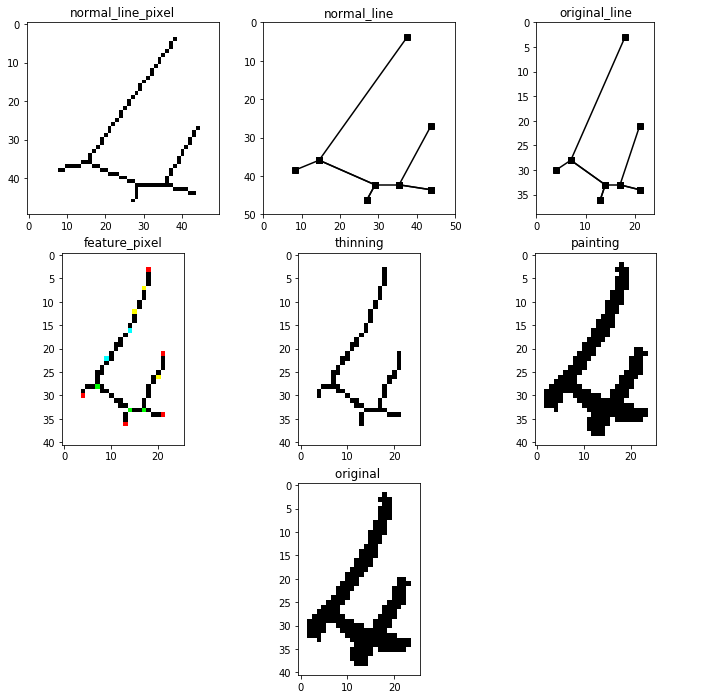

In [20]:
numbers=1234


locinfo=np.load('locinfo.npy')

f=open('rec.dat', 'rb')

testXY=[] # 세선화 이미지 검은색 좌표들


width,height,temp=read_f_file(f,numbers) #원본

img_Painting = painting(temp) #색칠전처리

BW_Skeleton = zhangSuen(img_Painting) #세선화전처리


testXY=caltestXY(width,height,testXY)


get_test, linkpoint=featuring(BW_Skeleton,testXY) #특징 추출


normalimg=getnormalimg(linkpoint)

fig, ax = plt.subplots(3,3, figsize=(12, 12))


make_graph1(normalimg,ax[0,0],width,height)
    
make_graph2(linkpoint,ax[0,1],width,height)

make_graph3(linkpoint,ax[0,2],width,height)

make_graph4(get_test,ax[1,0],width,height)

make_graph5(BW_Skeleton,ax[1,1],width,height)

make_graph6(img_Painting,ax[1,2],width,height)

make_graph7(temp,ax[2,1],width,height)

ax[2,0].axis(False)
ax[2,2].axis(False)
plt.show()

f.close()

In [52]:
import sys
from PyQt5.QtWidgets import QWidget, QApplication, QPushButton, QVBoxLayout, QHBoxLayout
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import struct
from PIL import Image
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import skimage.io as io
from skimage.filters import threshold_otsu

import math
import matplotlib.image as img

import cv2

%matplotlib inline

class MyWindow(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()
        
        self.numbers=0
        
        self.locinfo=np.load('locinfo.npy')
        self.f=open('rec.dat', 'rb')
        
        self.testXY=[]
        
        
        
        
        self.setLayout(self.layout)
        self.setGeometry(200, 200, 800, 400)

    def initUI(self):

        self.pushButton = QPushButton("DRAW Graph")
        self.pushButton.clicked.connect(self.btnClicked)

        self.fig, self.ax = plt.subplots(3,3, figsize=(12, 12))
        self.canvas = FigureCanvas(self.fig)

        # btn layout
        btnLayout = QVBoxLayout()
        btnLayout.addWidget(self.canvas)

        # canvas Layout
        canvasLayout = QVBoxLayout()
        canvasLayout.addWidget(self.pushButton)
        canvasLayout.addStretch(1)

        self.layout = QHBoxLayout()
        self.layout.addLayout(btnLayout)
        self.layout.addLayout(canvasLayout)

    def btnClicked(self):
        self.width, self.height, self.temp=read_f_file(self.f, self.numbers,self.locinfo)
        
        self.image = Image.new("RGB",(width+4,height+4),(255,255,255))
        self.im = self.image.load()
        for j in range(self.height+4):
            for i in range(self.width+4):

                if(self.temp[i][j]==1):
                    R = 0
                    G = 0
                    B = 0
                    self.im[i,j] = (R,G,B)
        self.ax[0,0].set_title('original')
        self.ax[0,0].imshow(np.asarray(self.image))
        

        self.image.close()
        self.canvas.draw() 

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = MyWindow()
    window.show()
    app.exec_()

TypeError: read_f_file() takes 2 positional arguments but 3 were given